Monte Carlo Sampling Benchmark Program - Cirq
... using circuit method 2
... execution starting at Sep 26, 2024 05:36:25 UTC
************
Executing [1] circuits with num_qubits = 4
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 354, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 178, 0, 0
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.002, 0.496, 0.024 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 1.0, 1.0

************
Executing [1] circuits with num_qubits = 5
Average Circuit Algorithmic Depth, ξ (xi) for the 5 qubit group = 823, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 5 qubit group = 412, 0, 0
Average Creation, Elapsed, Execution Time for the 5 qubit group = 0.002, 1.162, 0.052 secs
Average Hellinger, Normalized Fidelity for the 5 qubit group = 1.0, 1.0

************
Executing [1] circuits with num_qubits = 6
Average Circuit Algorithmic Depth, ξ (xi) for the 6 qubit

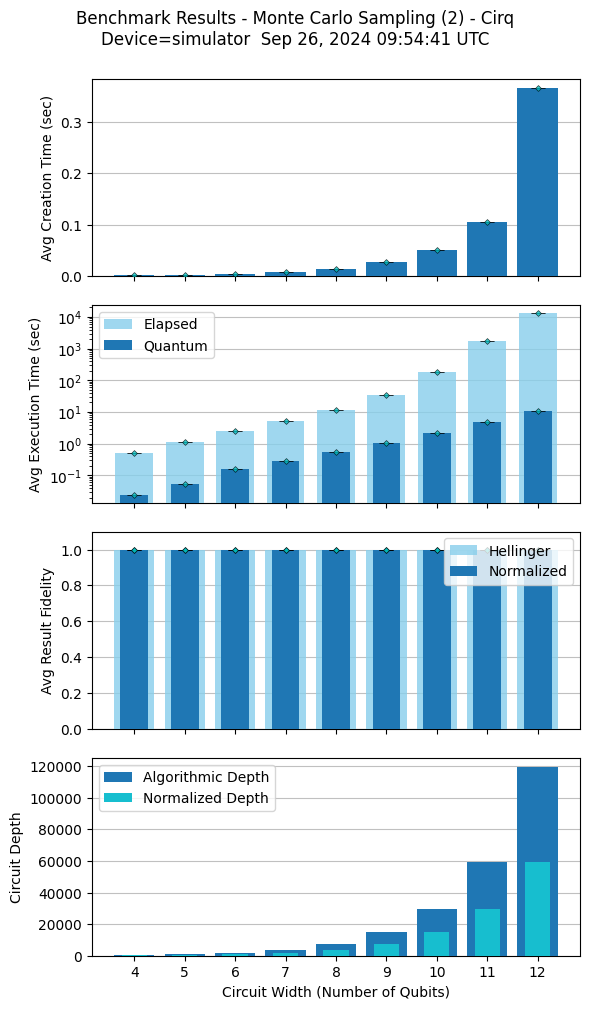

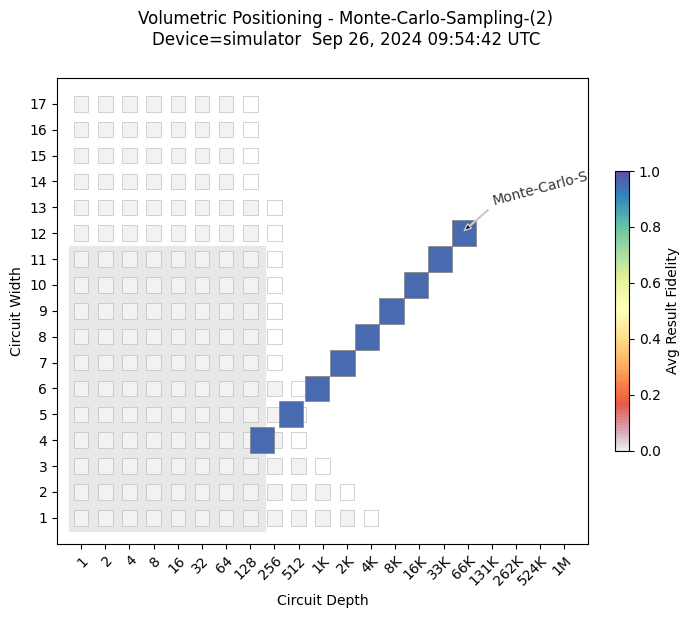

In [1]:
"""
Monte Carlo Sampling Benchmark Program via Amplitude Estimation- Cirq
"""

from collections import defaultdict
import copy
import functools
import sys
import time

import cirq
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.polynomial import polyfit

sys.path[1:1] = ["_common", "_common/cirq", "monte-carlo/_common", "quantum-fourier-transform/cirq"]
sys.path[1:1] = ["../../_common", "../../_common/cirq", "../../monte-carlo/_common", "../../quantum-fourier-transform/cirq"]
import cirq_utils as cirq_utils
import execute as ex
import mc_utils as mc_utils
import metrics as metrics
from qft_benchmark import inv_qft_gate

np.random.seed(0)

# default function is f(x) = x^2
f_of_X = functools.partial(mc_utils.power_f, power=2)

# default distribution is gaussian distribution
p_distribution = mc_utils.gaussian_dist

verbose = False

# saved subcircuits circuits for printing
A_ = None
Q_ = None
cQ_ = None
QC_ = None
QFTI_ = None
############### Circuit Definition

def MonteCarloSampling(target_dist, f, num_state_qubits, num_counting_qubits, epsilon=0.05, degree=2, method=2):
    
    A_qr = [cirq.GridQubit(i, 0) for i in range(num_state_qubits+1)]
    A = cirq.Circuit()
    
    num_qubits = num_state_qubits + 1 + num_counting_qubits
    
    # method 1 takes in the abitrary function f and arbitrary dist
    if method == 1:
        state_prep(A, A_qr, target_dist, num_state_qubits)
        f_on_objective(A, A_qr, f, epsilon=epsilon, degree=degree)
    # method 2 chooses to have lower circuit depth by choosing specific f and dist
    elif method == 2:
        uniform_prep(A, A_qr, num_state_qubits)
        square_on_objective(A, A_qr)
    
    qc = AE_Subroutine(num_state_qubits, num_counting_qubits, A)
    
    # save smaller circuit example for display
    global QC_    
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc

    return qc

###############              
                    
def f_on_objective(qc, qr, f, epsilon=0.05, degree=3):
    """
    Assume last qubit is the objective. Function f is evaluated on first n-1 qubits
    """
    num_state_qubits = len(qr) - 1
    c_star = (2*epsilon)**(1/(degree+1))
    
    f_ = functools.partial(f, num_state_qubits=num_state_qubits)
    zeta_ = functools.partial(mc_utils.zeta_from_f, func=f_, epsilon=epsilon, degree=degree, c=c_star)
    
    x_eval = np.linspace(0.0, 2**(num_state_qubits) - 1, num= degree+1)
    poly = Polynomial(polyfit(x_eval, zeta_(x_eval), degree))
    
    b_exp = mc_utils.binary_expansion(num_state_qubits, poly)
    
    for controls in b_exp.keys():
        theta = 2*b_exp[controls]
        controls = list(controls)
        if len(controls)==0:
            qc.append(cirq.ry(-theta).on(qr[num_state_qubits]))
        else:
            qc.append(cirq.ry(-theta).controlled(num_controls=len(controls)).on(*[qr[i] for i in controls]+[qr[num_state_qubits]]))

def square_on_objective(qc, qr):
      """
      Assume last qubit is the objective.
      Shifted square wave function: if x is even, f(x) = 0; if x i s odd, f(x) = 1
      """
      num_state_qubits = len(qr) - 1
      for control in range(num_state_qubits):
          qc.append(cirq.CX.on(qr[control], qr[num_state_qubits]))

def state_prep(qc, qr, target_dist, num_state_qubits):
    """
    Use controlled Ry gates to construct the superposition Sum \sqrt{p_i} |i>
    """
    r_probs = mc_utils.region_probs(target_dist, num_state_qubits)
    regions = r_probs.keys()
    r_norm = {}
    
    for r in regions:
        num_controls = len(r) - 1
        super_key = r[:num_controls]

        if super_key=='':
            r_norm[super_key] = 1
        elif super_key == '1':
            r_norm[super_key] = r_probs[super_key]
            r_norm['0'] = 1-r_probs[super_key]
        else:
            try:
                r_norm[super_key] = r_probs[super_key]
                
            except KeyError:
                r_norm[super_key] = r_norm[super_key[:num_controls-1]] - r_probs[super_key[:num_controls-1] + '1']
        
        
        norm = r_norm[super_key]
        p = 0
        if norm != 0:
            p = r_probs[r] / norm
        theta = -2*np.arcsin(np.sqrt(p))
        
        if r == '1':
            qc.append(cirq.ry(theta).on(qr[num_state_qubits-1]))
        else:
            for k in range(num_controls):    
                if r[k] == '0':
                    qc.append(cirq.X.on(qr[num_state_qubits-1 - k]))
            
            controls = [qr[num_state_qubits-1 - i] for i in range(num_controls)]
            qc.append(cirq.ry(theta).controlled(num_controls=num_controls).on(*controls+[qr[num_state_qubits-1-num_controls]]))
            
            for k in range(num_controls):    
                if r[k] == '0':
                    qc.append(cirq.X.on(qr[num_state_qubits-1 - k]))

def uniform_prep(qc, qr, num_state_qubits):
    """
    Generates a uniform distribution over all states
    """
    for i in range(num_state_qubits):
        qc.append(cirq.H.on(qr[i]))                  
            
def AE_Subroutine(num_state_qubits, num_counting_qubits, A_circuit):
    qr_state = cirq.GridQubit.rect(1,num_state_qubits+1,0)
    qr_counting = cirq.GridQubit.rect(1,num_counting_qubits,1)
    qc_full = cirq.Circuit()

    A = cirq_utils.to_gate(num_state_qubits+1, A_circuit, name="A")
    cQ, Q = Ctrl_Q(num_state_qubits, A_circuit)

    # save small example subcircuits for visualization
    global A_, Q_, cQ_, QFTI_
    if cQ_ == None or num_state_qubits <= 6:
        if num_state_qubits < 9: cQ_ = cQ
    if (Q_ or A_) == None or num_state_qubits <= 3:
        if num_state_qubits < 5: A_ = A; Q_ = Q
    if QFTI_ == None or num_counting_qubits <= 3:
        if num_counting_qubits < 4: QFTI_ = inv_qft_gate(num_counting_qubits)

    # Prepare state from A, and counting qubits with H transform
    qc_full.append(A.on(*qr_state))
    for i in range(num_counting_qubits):
        qc_full.append(cirq.H.on(qr_counting[i]))
    
    repeat = 1
    for j in reversed(range(num_counting_qubits)):
        for _ in range(repeat):
            qc_full.append(cQ.on(*[qr_counting[j]]+qr_state))
        repeat *= 2

    # inverse quantum Fourier transform only on counting qubits
    QFT_inv_gate = inv_qft_gate(num_counting_qubits)
    qc_full.append(QFT_inv_gate.on(*qr_counting))

    qc_full.append(cirq.measure(*qr_counting, key='result'))

    return qc_full
            
            
###############################
    
# Construct the grover-like operator and a controlled version of it
def Ctrl_Q(num_state_qubits, A_circ):

    # index n is the objective qubit, and indexes 0 through n-1 are state qubits
    qr_Q = cirq.GridQubit.rect(1,num_state_qubits+1,0)
    qc_Q = cirq.Circuit()
    
    A_gate = cirq_utils.to_gate(num_state_qubits+1, A_circ, name="A")
    A_gate_inv = cirq.inverse(copy.copy(A_gate))
    
    ### Each cycle in Q applies in order: -S_chi, A_circ_inverse, S_0, A_circ 
    # -S_chi
    qc_Q.append(cirq.X(qr_Q[num_state_qubits]))
    qc_Q.append(cirq.Z(qr_Q[num_state_qubits]))
    qc_Q.append(cirq.X(qr_Q[num_state_qubits]))
        
    # A_circ_inverse
    qc_Q.append(A_gate_inv.on(*qr_Q))
        
    # S_0
    for i in range(num_state_qubits+1):
        qc_Q.append(cirq.X.on(qr_Q[i]))
    qc_Q.append(cirq.H(qr_Q[num_state_qubits]))
    
    qc_Q.append(cirq.X.controlled(num_controls=num_state_qubits).on(*qr_Q))
    
    qc_Q.append(cirq.H(qr_Q[num_state_qubits]))
    for i in range(num_state_qubits+1):
        qc_Q.append(cirq.X.on(qr_Q[i]))
        
    # A_circ
    qc_Q.append(A_gate.on(*qr_Q))
    
    # Create a gate out of the Q operator
    Q_ = cirq_utils.to_gate(num_qubits=num_state_qubits+1, circ=qc_Q, name="Q")
    
    # and also a controlled version of it
    Ctrl_Q_ = cirq.ops.ControlledGate(Q_, num_controls=1)
    
    # and return both
    return Ctrl_Q_, Q_

#########################################

# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result(qc, result, num_counting_qubits, mu, num_shots, method, num_state_qubits):

    # generate exact value for the expectation value given our function and dist
    target_dist = p_distribution(num_state_qubits, mu)
    f = functools.partial(f_of_X, num_state_qubits=num_state_qubits)
    if method == 1:
        exact = mc_utils.estimated_value(target_dist, f)
    elif method == 2:
        exact = 0.5 # hard coded exact value from uniform dist and square function
    
    # obtain bit_counts from the result object
    measurements = result.measurements['result']
    bit_counts = defaultdict(lambda: 0)
    for row in measurements:
        bit_counts["".join([str(x) for x in reversed(row)])] += 1
    
    # convert bit_counts into expectation values counts according to Quantum Risk Analysis paper
    counts = expectation_from_bits(bit_counts, num_counting_qubits, num_shots, method)

    # Convert keys of counts to strings
    counts = {str(key): value for key, value in counts.items()}
    
    # calculate the distribution we should expect from the amplitude estimation routine
    correct_dist = mc_utils.mc_dist(num_counting_qubits, exact, c_star, method)
    
    # Convert keys of correct_dist to strings
    correct_dist = {str(key): value for key, value in correct_dist.items()}

    # generate thermal_dist with amplitudes instead, to be comparable to correct_dist
    bit_thermal_dist = metrics.uniform_dist(num_counting_qubits)
    thermal_dist = expectation_from_bits(bit_thermal_dist, num_counting_qubits, num_shots, method)

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist, thermal_dist)

    ###########################################################################
    # NOTE: in this benchmark, we are testing how well the amplitude estimation routine
    #       works according to theory, and we do not measure the difference between
    #       the reported answer and the correct answer; the below code just helps
    #       demonstrate that we do approximate the expectation value accurately.

    # the max in the counts is what the algorithm would report as the correct answer
    a, _ = mc_utils.value_and_max_prob_from_dist(counts)

    if verbose: print(f"For expected value {exact} measured: {a}")
    ###########################################################################
    
    if verbose: print(f"Solution counts: {counts}")
        
    return counts, fidelity

def expectation_from_bits(bits, num_qubits, num_shots, method):
    amplitudes = {}
    for b in bits.keys():
        precision = int(num_qubits / (np.log2(10))) + 2

        r = bits[b]
        a_meas = pow(np.sin(np.pi*int(b,2)/pow(2,num_qubits)),2)
        if method == 1:
            a = ((a_meas - 0.5)/c_star) + 0.5
        if method == 2:
            a = a_meas
        a = round(a, precision)
        
        if a not in amplitudes.keys():
            amplitudes[a] = 0
        amplitudes[a] += r
    
    return amplitudes


################ Benchmark Loop

MIN_QUBITS = 4    # must be at least MIN_STATE_QUBITS + 3
MIN_STATE_QUBITS = 1

# set minimums for method 1
MIN_QUBITS_M1 = 5 # must be at least MIN_STATE_QUBITS + 3
MIN_STATE_QUBITS_M1 = 2

# Because circuit size grows significantly with num_qubits
# limit the max_qubits here ...
MAX_QUBITS=30

# Execute program with default parameters
def run(min_qubits=MIN_QUBITS, max_qubits=12, max_circuits=1, num_shots=1000, 
        epsilon=0.05, degree=2, num_state_qubits=MIN_STATE_QUBITS, method=2, # default, not exposed to users
        backend_id='simulator', provider_backend=None):

    print("Monte Carlo Sampling Benchmark Program - Cirq")
    print(f"... using circuit method {method}")

    # Clamp the maximum number of qubits
    if max_qubits > MAX_QUBITS:
        print(f"INFO: Monte Carlo Sampling benchmark is limited to a maximum of {MAX_QUBITS} qubits.")
        max_qubits = MAX_QUBITS
    
    if (method == 2):
        if max_qubits < MIN_QUBITS:
            print(f"INFO: Monte Carlo Simulation benchmark method ({method}) requires a minimum of {MIN_QUBITS} qubits.")
            return
        if min_qubits < MIN_QUBITS:
            min_qubits = MIN_QUBITS
    
    elif (method == 1):
        if max_qubits < MIN_QUBITS_M1:
            print(f"INFO: Monte Carlo Simulation benchmark method ({method}) requires a minimum of {MIN_QUBITS_M1} qubits.")
            return
        if min_qubits < MIN_QUBITS_M1:
            min_qubits = MIN_QUBITS_M1

    if (method == 1) and (num_state_qubits == MIN_STATE_QUBITS):
        num_state_qubits = MIN_STATE_QUBITS_M1
         
    ### TODO: need to do more validation of arguments, e.g. min_state_qubits and min_qubits
        
    # Initialize metrics module
    metrics.init_metrics()
    
    global c_star
    c_star = (2*epsilon)**(1/(degree+1))

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, mu, num_shots):
        # determine fidelity of result set
        num_counting_qubits = int(num_qubits) - num_state_qubits -1
        counts, fidelity = analyze_and_print_result(qc, result, num_counting_qubits, float(mu), num_shots, method=method, num_state_qubits=num_state_qubits)
        metrics.store_metric(num_qubits, mu, 'fidelity', fidelity)

    # Initialize execution module   with the result handler  
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1):

        input_size = num_qubits - 1 # TODO: keep using inputsize? only used in num_circuits
        
        # as circuit width grows, the number of counting qubits is increased
        num_counting_qubits = num_qubits - num_state_qubits - 1
        
        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (input_size), max_circuits)

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        

        # determine range of circuits to loop over for method 1
        if 2**(input_size) <= max_circuits:
            mu_range = [i/2**(input_size) for i in range(num_circuits)]
        else:
            mu_range = [i/2**(input_size) for i in np.random.choice(2**(input_size), num_circuits, False)]

        # loop over limited # of mu values for this
        for mu in mu_range:
            target_dist = p_distribution(num_state_qubits, mu)
            f_to_estimate = functools.partial(f_of_X, num_state_qubits=num_state_qubits)
            
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()

            qc = MonteCarloSampling(target_dist, f_to_estimate, num_state_qubits, num_counting_qubits, epsilon, degree, method=method)
            metrics.store_metric(num_qubits, mu, 'create_time', time.time() - ts)

            qc = cirq.Circuit(cirq.decompose(op) for op in qc.all_operations())
                
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, mu, num_shots)

            # if method is 2, we only have one type of circuit, so break out of loop
            if method == 2:
                break
        
        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    # ex.execute_circuits()
    # metrics.aggregate_metrics_for_group(num_qubits)
    # metrics.report_metrics_for_group(num_qubits)

    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    qr_state = cirq.GridQubit.rect(1,num_state_qubits+1,0) # we need to create registers to print circuits in cirq
    qr_control = cirq.GridQubit.rect(1,1,1)
    print("\nControlled Quantum Operator 'cQ' ="); print(cirq.Circuit(cQ_.on(qr_control[0], *qr_state)) if cQ_ != None else "  ... too large!")
    print("\nQuantum Operator 'Q' ="); print(cirq.Circuit(cirq.decompose(Q_.on(*qr_state))) if Q_ != None else "  ... too large!")
    print("\nAmplitude Generator 'A' ="); print(cirq.Circuit(cirq.decompose(A_.on(*qr_state))) if A_ != None else "  ... too large!")

    qr_state = cirq.GridQubit.rect(1,QFTI_.num_qubits,0) # we need to create registers to print circuits in cirq
    print("\nInverse QFT Circuit ="); print(cirq.Circuit(cirq.decompose(QFTI_.on(*qr_state))) if QFTI_ != None else "  ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - Monte Carlo Sampling ({method}) - Cirq")

# if main, execute method
if __name__ == '__main__': run()
